In [1]:
import pandas as pd
t = pd.read_csv("/home/jovyan/work/prj_data/open/train.csv")

### ※ 결측치 확인

In [2]:
import pandas as pd
missing_values = t.isnull().sum()
print(missing_values)

id          0
context     0
question    0
answer      0
dtype: int64


# 1. Sequence Length

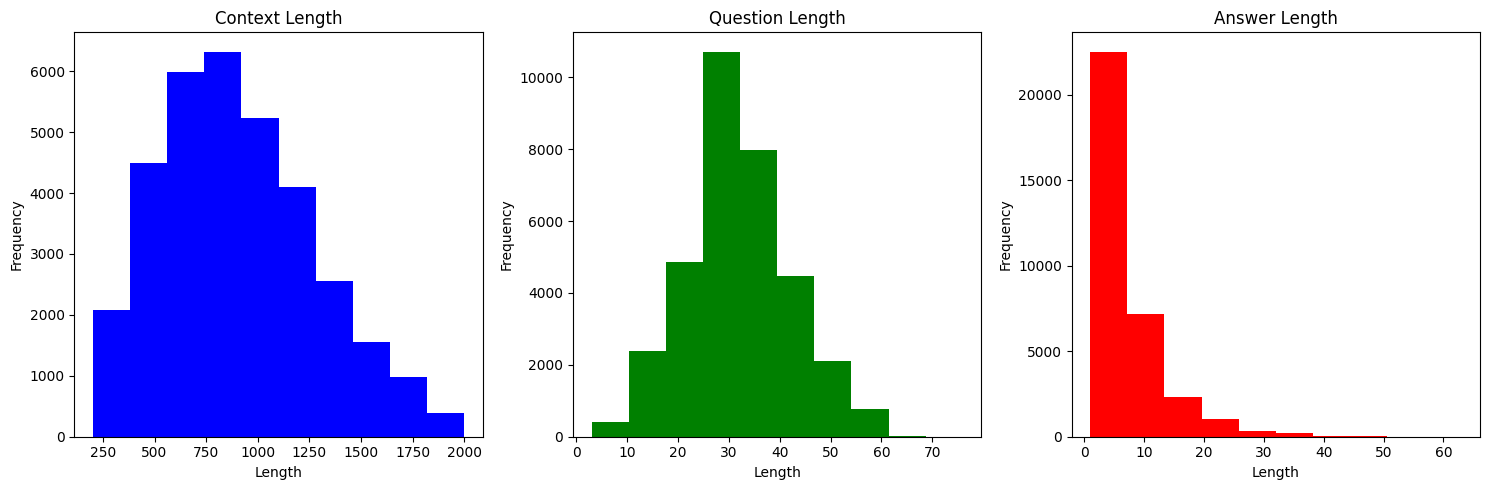

In [3]:
import matplotlib.pyplot as plt

context_l = t['context'].str.len()
question_l = t['question'].str.len()
answer_l = t['answer'].str.len()

l = [context_l, question_l, answer_l]
colors = ['blue', 'green', 'red']
titles = ['Context Length', 'Question Length', 'Answer Length']

# Plot the histograms
plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.hist(l[i], bins=10, color=colors[i])
    plt.title(titles[i])
    plt.xlabel('Length')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## 1) Max Length

In [4]:
print("# Max Length")
print("Max Context Length: ", max(context_l))
print("Max Question Length: ", max(question_l))
print("Max Answer Length: ", max(answer_l))

# Max Length
Max Context Length:  2000
Max Question Length:  76
Max Answer Length:  63


In [5]:
print("# Question Example (length: 76)")
print("Q: ", t[t['question'].str.len() == 76]['question'][6456])
print("A: ", t['answer'][6456])
print("\n# Answer Example (length: 63)")
print("Q: ", t['question'][29405])
print("A: ", t[t['answer'].str.len() == 63]['answer'][29405])

# Question Example (length: 76)
Q:  지난해 과기정통부가 구축한 국가 인재 개발 지능형 공개 플랫폼과 디지털 우정 물류 공유 플랫폼의 민간 혁신 서비스 개발을 지원하는 금액은
A:  5억 원

# Answer Example (length: 63)
Q:  어떤 분야의 기술 개발을 돕기 위해 4군데의 과기원이 모였어
A:  첨단소재, 공정장비, 바이오·헬스케어, 정보통신기술(ICT)·소프트웨어(SW), 기계항공, 제조 자동화·지능화 등


## 2) Mean, Std

In [6]:
import numpy as np

titles = ["## Context", "## Question", "## Answer"]
for i in range(3):
    print(titles[i])
    print("95퍼센트의 길이: {:.2f}".format(np.percentile(l[i], 95)))
    print("평균 길이: {:.2f}".format(np.mean(l[i])))
    print("중앙값 길이: {:.2f}".format(np.median(l[i])))
    print("표준편차: {:.2f}\n".format(np.std(l[i])))

## Context
95퍼센트의 길이: 1598.00
평균 길이: 901.54
중앙값 길이: 862.00
표준편차: 372.21

## Question
95퍼센트의 길이: 50.00
평균 길이: 31.91
중앙값 길이: 31.00
표준편차: 10.26

## Answer
95퍼센트의 길이: 20.00
평균 길이: 7.39
중앙값 길이: 6.00
표준편차: 5.97



# 2. Tokenized Length

In [8]:
from transformers import AutoTokenizer
from tqdm import tqdm
from datasets import load_dataset
import re

repo = 'yjgwak/klue-bert-base-finetuned-squad-kor-v1'
tokenizer = AutoTokenizer.from_pretrained(repo)
dataset = load_dataset("csv", data_files="/home/jovyan/work/prj_data/open/train.csv")

### 1) Max, Mean, Std

Token indices sequence length is longer than the specified maximum sequence length for this model (779 > 512). Running this sequence through the model will result in indexing errors


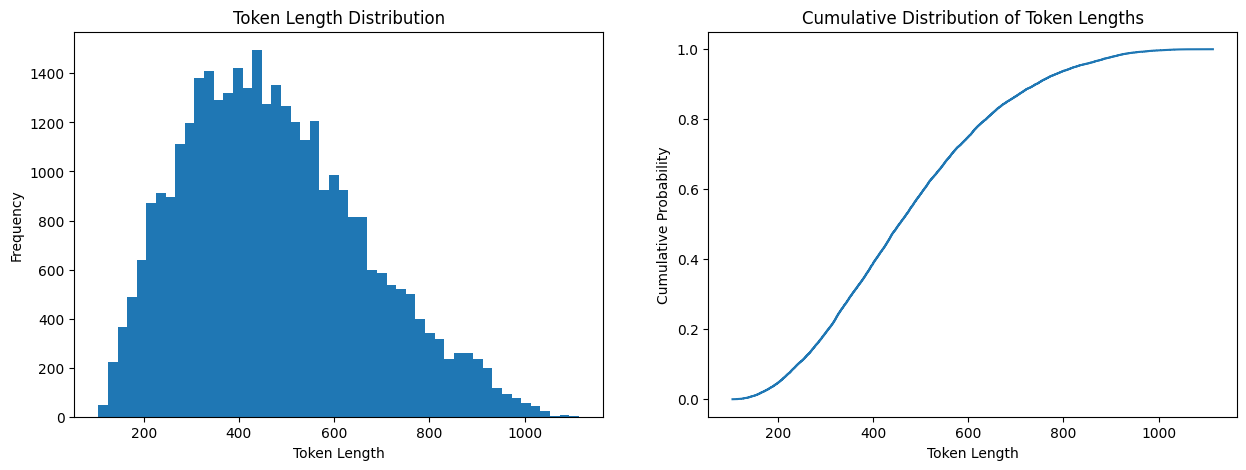

최대 길이: 1114
95퍼센트의 길이: 827.00
평균 길이: 476.12
중앙값 길이: 455.00
표준편차: 188.26



In [9]:
import matplotlib.pyplot as plt
import numpy as np

lengths = []
for example in dataset['train']:
    tokens = tokenizer(example['question'], example['context'], truncation=False)
    lengths.append(len(tokens['input_ids']))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(lengths, bins=50)
plt.title('Token Length Distribution')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

def cdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / len(data)
    return x, y

x, y = cdf(lengths)
plt.subplot(1, 2, 2)
plt.plot(x, y)
plt.title('Cumulative Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Cumulative Probability')
plt.show()

print(f"최대 길이: {np.max(lengths)}")
print("95퍼센트의 길이: {:.2f}".format(np.percentile(lengths, 95)))
print("평균 길이: {:.2f}".format(np.mean(lengths)))
print("중앙값 길이: {:.2f}".format(np.median(lengths)))
print("표준편차: {:.2f}\n".format(np.std(lengths)))

### 2) Start Point, End Point of Answers

In [10]:
max_length = 512
stride = 128

def preprocess_function(examples):
    questions, contexts, answers = examples["question"], examples["context"], examples["answer"]
    def preprocess_text(text):
        text = text.replace('\n', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    questions = list(map(preprocess_text, questions))
    contexts = list(map(preprocess_text, contexts))
    answers = list(map(preprocess_text, answers))

    inputs = tokenizer(
        questions,
        contexts,
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # offset_mapping: [(token1 start, token1 end), (token2 ~, ), ...]
    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs['overflow_to_sample_mapping']# inputs.pop("overflow_to_sample_mapping")
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]

        start_char = contexts[sample_idx].find(answer)
        end_char = start_char + len(answer)
        # sequence_ids: (token=None, question=0, context=1)
        sequence_ids = inputs.sequence_ids(i)

        # 컨텍스트의 시작 및 마지막을 찾는다.
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # 만일 정답이 컨텍스트에 완전히 포함되지 않는다면, 레이블은 (0, 0)임
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # 그렇지 않으면 정답의 시작 및 마지막 인덱스
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)
    
            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

# 데이터 프레임을 전처리합니다
# preprocess_function(dataset["train"][6])# [15281]
train_dataset = dataset["train"].map(
    preprocess_function,
    batched = True,
    remove_columns=dataset["train"].column_names,
)

Map: 100%|██████████| 33716/33716 [00:52<00:00, 640.90 examples/s]


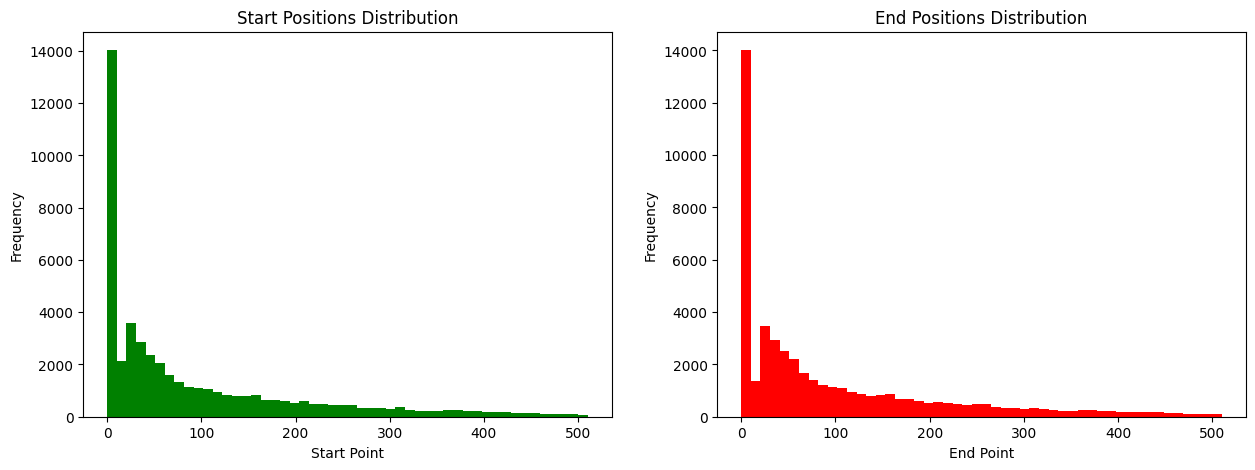

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(train_dataset['start_positions'], bins=50, color="green")
plt.title('Start Positions Distribution')
plt.xlabel('Start Point')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(train_dataset['end_positions'], bins=50, color="red")
plt.title('End Positions Distribution')
plt.xlabel('End Point')
plt.ylabel('Frequency')
plt.show()